In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
# Reading an animated GIF file using Python Image Processing Library - Pillow
from PIL import Image
from tensorflow.math import confusion_matrix as cm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler

In [2]:
#load all gif in train folder
train_images = [Image.open(file) for file in glob.glob("./Data/emotion_classification/train/*.gif")]

#Dimension of image
height,width=np.array(train_images[0]).shape
size=height*width

#number of data samples
N1=len(train_images)

#Target values corresponding to data samples (happy = 1 & sad = 0)
train_target=np.array([1,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0])

#load all gif in train folder
test_images = [Image.open(file) for file in glob.glob("./Data/emotion_classification/test/*.gif")]

N=len(test_images)

#Test target values
test_target=np.array([0,1,1,1,0,1,1,0,1,0])

In [3]:
# plt.imshow(train_images[0],cmap='gray')
# plt.imshow(test_images[0],cmap='gray')
# plt.show()

In [4]:
#flattening the data sample images from 101x101 to 1x10201  and storing into x_train
x_train=np.zeros((N1,size))
for i in range(len(train_images)):
    x_train[i,:]=np.array(train_images[i]).reshape(1,size)

x_test=np.zeros((N,size))
for i in range(len(test_images)):
    x_test[i,:]=np.array(test_images[i]).reshape(1,size)
    

pca = PCA(n_components=12)
pca_train = pca.fit_transform(x_train)
pca_test = pca.transform(x_test)

scaler = StandardScaler()
y_train = scaler.fit_transform(pca_train)
y_test = scaler.transform(pca_test)

In [5]:
scaler = StandardScaler()
std_train = scaler.fit_transform(x_train)
std_test = scaler.transform(x_test)

In [6]:
pca = PCA(n_components=12)
y_train = pca.fit_transform(std_train)
y_test = pca.transform(std_test)

In [7]:
def FCLayer(input_size, output_size):
    weights = np.random.rand(input_size, output_size) -0.5
    bias = np.random.rand(1, output_size) -0.5
    
    return weights, bias

In [8]:
def ReLU(x):
    x[x<0] = 0
    return x

In [9]:
def softmax(x):
    denom = np.sum(np.exp(x))
    return np.exp(x) / denom

In [10]:
def cross_entropy(y_true, y_predict):
    return - np.dot(y_true, np.log(y_predict))

In [11]:
def ReLU_backward(x):
    x[x<0] = 0
    x[x>0] = 1

    return x

In [12]:
def forward_prop(X, w1, w2, b1, b2):
    a1 = X@w1 + b1
    h1 = ReLU(a1)
    a2 = h1@w2 +b2
    h2 = softmax(a2)
    return a1, h1, a2, h2

In [13]:
def back_prop(y_train, one_hot_target, y_pred, w2, a1):
#     dL_dy_pred = loss_to_output(one_hot_target, y_pred)
    dL_da2 = y_pred - one_hot_target
    dL_dh1 = dL_da2.dot(w2.T)
    dL_da1 = dL_dh1 * ReLU_backward(a1)
    dL_dw2 = dL_dh1.T.dot(dL_da2)
    dL_db2 = dL_da2
    dL_dw1 = y_train.reshape(y_train.shape[0],1).dot(dL_da1)
    dL_db1 = dL_da1
    
    return dL_dw2, dL_db2, dL_dw1, dL_db1

In [14]:
def fit(y_train, train_target, hidden_layer_neurons, MAX_ITER, Learning_rate):
    
    one_hot_target = np.zeros((train_target.shape[0],2))
    
    for i,j  in enumerate(train_target):
        one_hot_target[i,j] = 1
        
    num, param = y_train.shape
    input_neurons = param
    output_class = np.unique(train_target).shape[0]

    w1, b1 = FCLayer(param, hidden_layer_neurons)
    w2, b2 = FCLayer(hidden_layer_neurons, output_class)
    loss_=[]
    for j in range(MAX_ITER):
        temp = 0
        for i in range(num):
            train = y_train[i]
    
            a1, h1, a2, y2 = forward_prop(train, w1, w2, b1, b2)
            dL_dw2, dL_db2, dL_dw1, dL_db1 = back_prop(train, one_hot_target[i], y2, w2, a1)
            w2 -= Learning_rate * dL_dw2
            b2 -= Learning_rate * dL_db2
            w1 -= Learning_rate * dL_dw1
            b1 -= Learning_rate * dL_db1

            temp+= cross_entropy(one_hot_target[i], y2.reshape(-1))
        loss_.append(temp)
        
    return w1, b1, w2, b2, loss_

In [15]:
def predict(y_test, test_target, w1, b1, w2, b2):
    num, param = y_test.shape
    pred = []
    hidden_neuron = w1.shape[1]
    for i in range(num):
        
        temp2 = y_test[i]

        a1, h1, a2, y2 = forward_prop(temp2, w1, w2, b1, b2)
        
        if y2[0,0]>y2[0,1]:
            pred.append(0)
        else:
            pred.append(1)
    count=0
    count=sum([1 for i in range(num) if pred[i] == test_target[i]])
    print(f'Accuracy: {count*100/num}% for hidden nuerons: {hidden_neuron}')            

In [16]:
np.random.seed(10)
hidden_layer_neurons = 10
MAX_ITER = 20
Learning_rate = 0.001

w1, b1, w2, b2, loss_10 = fit(y_train, train_target, hidden_layer_neurons, MAX_ITER, Learning_rate)
predict(y_test, test_target, w1, b1, w2, b2)

Accuracy: 60.0% for hidden nuerons: 10


In [17]:
np.random.seed(10)
hidden_layer_neurons = 15
MAX_ITER = 20
Learning_rate = 0.001

w1, b1, w2, b2, loss_15 = fit(y_train, train_target, hidden_layer_neurons, MAX_ITER, Learning_rate)
predict(y_test, test_target, w1, b1, w2, b2)

Accuracy: 90.0% for hidden nuerons: 15


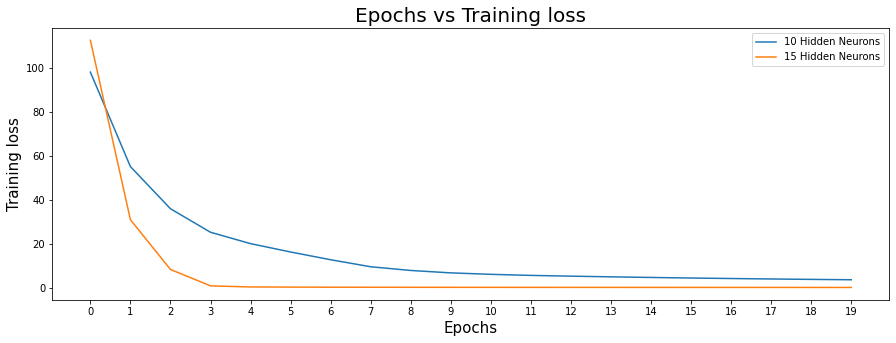

In [18]:
X = range(MAX_ITER)
plt.figure(figsize=(15,5))
plt.plot(X, loss_10, label="10 Hidden Neurons")
plt.plot(X,loss_15 ,label="15 Hidden Neurons")
plt.xticks(X)
plt.xlabel("Epochs", size=15)
plt.ylabel("Training loss", size=15)
plt.title("Epochs vs Training loss", size=20)
plt.legend()
plt.show()